### Build some baseline models 
Refer to in this [reference](https://towardsdatascience.com/time-series-classification-for-human-activity-recognition-with-lstms-using-tensorflow-2-and-keras-b816431afdff)

In [37]:
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras

#### Read in the datasets and scale them

In [3]:
df_ms = pd.read_csv('./01_rawdata/raw_ms_all0926_df.csv') # read in the ms datasets
df_wd = pd.read_csv('./01_rawdata/raw_wisdm0926_df.csv')  # read in the wisdm datasets

In [4]:
df_wd.head(2)

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424


In [5]:
df_ms.head(2) # The MS (iPhones) datasets had more features than the WIDSM (Android phones) datasets

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,...,weight,height,age,gender,trial,x_axis,y_axis,z_axis,user_id,activity
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,...,102.0,188.0,46.0,1.0,1.0,1.036789,0.485275,0.345870,50.0,Downstairs
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,...,102.0,188.0,46.0,1.0,1.0,0.972504,0.692962,0.082611,50.0,Downstairs


In [6]:
# Splitting training and testing by users
df_wd_train = df_wd[df_wd['user_id'] <= 30]
df_wd_test = df_wd[df_wd['user_id'] > 30]
df_ms_train = df_ms[df_ms['user_id'] <= 66]
df_ms_test = df_ms[df_ms['user_id'] > 66]

In [7]:
print(df_wd_train.shape, df_wd_test.shape, df_ms_train.shape, df_ms_test.shape)

(898360, 6) (199843, 6) (992434, 22) (420431, 22)


In [8]:
df_wd_train.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
8489,17,Walking,57869902574000,0.572055,9.806650,-0.531194
8490,17,Walking,57870012316000,-0.000000,10.188020,-0.572055
8491,17,Walking,57870122301000,-0.231546,9.847511,-0.694638
8492,17,Walking,57870222246000,0.149824,10.079058,-0.503953
8493,17,Walking,57870332292000,0.149824,10.147159,-0.612916


In [9]:
df_wd_test.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [10]:
#define a function to scale the features for building the models
def robustscale_data(df_train,df_test,cols,scaler=RobustScaler()):
    scale_columns = cols
    scaler = scaler.fit(df_train[scale_columns])
    df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
    df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())
    return df_train,df_test

In [11]:
# scale the acceleration in the WISDM datasets
df_wd_train,df_wd_test = robustscale_data(df_wd_train,df_wd_test,['x_axis', 'y_axis', 'z_axis'])

C:\Users\fuzha\anaconda3\envs\proj\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\Users\fuzha\anaconda3\envs\proj\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [12]:
df_wd_train.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
8489,17,Walking,57869902574000,0.019955,0.252293,-0.090959
8490,17,Walking,57870012316000,-0.055118,0.297966,-0.099228
8491,17,Walking,57870122301000,-0.085505,0.257187,-0.124035
8492,17,Walking,57870222246000,-0.035456,0.284917,-0.085446
8493,17,Walking,57870332292000,-0.035456,0.293073,-0.107497


In [13]:
df_wd_test.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.146278,0.596472,0.118522
1,33,Jogging,49106062271000,0.602662,0.426830,0.209481
2,33,Jogging,49106112167000,0.588363,0.381157,0.000000
3,33,Jogging,49106222305000,-0.135553,1.292986,0.628442
4,33,Jogging,49106332290000,-0.210626,0.527963,1.474634


In [14]:
df_ms_train[['x_axis', 'y_axis', 'z_axis']].head(3)

,x_axis,y_axis,z_axis
0,1.036789,0.485275,0.345870
1,0.972504,0.692962,0.082611
2,0.770325,0.784256,-0.200515


In [15]:
df_ms_test[['x_axis', 'y_axis', 'z_axis']].head(3)

,x_axis,y_axis,z_axis
992434,-0.084092,0.649170,-0.117401
992435,-0.069015,0.516800,-0.139694
992436,0.034592,0.494324,-0.192841


In [16]:
# scale the acceleration in the WISDM datasets
df_ms_train,df_ms_test = robustscale_data(df_ms_train,df_ms_test,['x_axis', 'y_axis', 'z_axis'])

C:\Users\fuzha\anaconda3\envs\proj\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\Users\fuzha\anaconda3\envs\proj\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [17]:
df_ms_test[['x_axis', 'y_axis', 'z_axis']].head(3)

,x_axis,y_axis,z_axis
992434,-0.298364,-0.334976,-0.173145
992435,-0.271320,-0.550886,-0.213503
992436,-0.085477,-0.587546,-0.309718


In [18]:
df_ms_train[['x_axis', 'y_axis', 'z_axis']].head(3)

,x_axis,y_axis,z_axis
0,1.712199,-0.602306,0.665536
1,1.596889,-0.263547,0.188946
2,1.234233,-0.114637,-0.323610


**Note**
- Now both the MS and WISDM datasets were scaled
- Next, we need to format the data to build the models

#### Create datasets for building models

- Each data point to build the model is an 2D array with size of (L,M), where L represents the number of samples take from the time series and M represents the number of features.
- When building the baseline models, I used L = 200 for both MS and WIDSM datasets. As we will see later, the optimized L will be different for the two cases.
- Since WISDM datasets only have acceleration('x_axis', 'y_axis', 'z_axis') recorded, M=3 for this case.

In [19]:
def create_dataset(X, y, time_steps=1, step=1):
    '''
    This function creats the timeseries data from the raw datasets.
    X: The input features for building the model
    y: The labels for the corresponding input dataset
    time_step: The window length (number of samples in the time series) of each of the training datasets
    step: The moving distance for the window to generate the next training datasets.
    The difference from (time_step - step) gives the number of overlapping samples between the two nearby rows of training dataset.
    '''
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [20]:
def create_dataset_X(X, time_steps=1, step=1):
    '''
    This function is very similar as the above function. The only difference is this function does not need inputting labels
    Using this function to create validation datasets.
    '''
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
#        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
#        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs)#, np.array(ys).reshape(-1, 1)

##### Create model building datasets for WISDM

In [21]:
df_wd_train.columns[:]

Index(['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis'], dtype='object')

In [24]:
TIME_STEPS = 200
STEP = 40

X_wd_train, y_wd_train = create_dataset(
    df_wd_train[df_wd.columns[-3:]],
    df_wd_train.activity,
    TIME_STEPS,
    STEP
)

X_wd_test, y_wd_test = create_dataset(
    df_wd_test[df_wd.columns[-3:]],
    df_wd_test.activity,
    TIME_STEPS,
    STEP
)

In [25]:
print(X_wd_train.shape, y_wd_train.shape)

(22454, 200, 3) (22454, 1)


In [26]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_wd_train)

y_wd_train = enc.transform(y_wd_train)
y_wd_test = enc.transform(y_wd_test)

In [27]:
print(X_wd_train.shape, y_wd_train.shape)

(22454, 200, 3) (22454, 6)


In [28]:
print(X_wd_test.shape, y_wd_test.shape)

(4992, 200, 3) (4992, 6)


In [48]:
model_wd = keras.Sequential()
model_wd.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_wd_train.shape[1], X_wd_train.shape[2]]
      )
    )
)
model_wd.add(keras.layers.Dropout(rate=0.5))
model_wd.add(keras.layers.Dense(units=128, activation='relu'))
model_wd.add(keras.layers.Dense(y_wd_train.shape[1], activation='softmax'))
model_wd.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [49]:
history_wd = model_wd.fit(
    X_wd_train, y_wd_train,
    epochs=6,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)

Epoch 1/6
316/316 [==============================] - 133s 421ms/step - loss: 1.0552 - acc: 0.6382 - val_loss: 0.8573 - val_acc: 0.7587
Epoch 2/6
316/316 [==============================] - 137s 435ms/step - loss: 0.8200 - acc: 0.7152 - val_loss: 0.8130 - val_acc: 0.7760
Epoch 3/6
316/316 [==============================] - 142s 448ms/step - loss: 0.6913 - acc: 0.7586 - val_loss: 0.8987 - val_acc: 0.7386
Epoch 4/6
316/316 [==============================] - 146s 463ms/step - loss: 0.6149 - acc: 0.7785 - val_loss: 0.7616 - val_acc: 0.7747
Epoch 5/6
316/316 [==============================] - 147s 466ms/step - loss: 0.5535 - acc: 0.7925 - val_loss: 0.6386 - val_acc: 0.7845
Epoch 6/6
316/316 [==============================] - 146s 463ms/step - loss: 0.5191 - acc: 0.8010 - val_loss: 0.6987 - val_acc: 0.8139


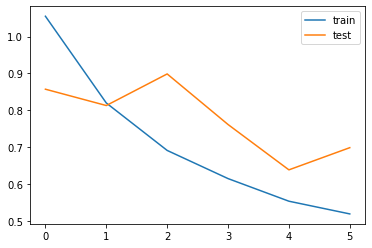

In [50]:
plt.plot(history_wd.history['loss'], label='train')
plt.plot(history_wd.history['val_loss'], label='test')
plt.legend();

In [51]:
model_wd.evaluate(X_wd_test,y_wd_test)

156/156 [==============================] - 6s 40ms/step - loss: 0.7664 - acc: 0.7788


[0.7663702368736267, 0.7788461446762085]

In [52]:
model_wd.save('./02_models/0926wd_lstm_md.h5')

**Note** The baseline of RNN LSTM model for the WISDM model was 0.78

##### Create model building datasets for MS

In [29]:
df_ms_train.columns[:]

Index(['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x',
       'gravity.y', 'gravity.z', 'rotationRate.x', 'rotationRate.y',
       'rotationRate.z', 'userAcceleration.x', 'userAcceleration.y',
       'userAcceleration.z', 'weight', 'height', 'age', 'gender', 'trial',
       'x_axis', 'y_axis', 'z_axis', 'user_id', 'activity'],
      dtype='object')

In [30]:
TIME_STEPS = 200
STEP = 40

X_ms_train, y_ms_train = create_dataset(
    df_ms_train[df_ms.columns[17:20]],
    df_ms_train.activity,
    TIME_STEPS,
    STEP
)

X_ms_test, y_ms_test = create_dataset(
    df_ms_test[df_ms.columns[17:20]],
    df_ms_test.activity,
    TIME_STEPS,
    STEP
)

In [31]:
print(X_ms_train.shape, y_ms_train.shape)

(24806, 200, 3) (24806, 1)


In [32]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_ms_train)

y_ms_train = enc.transform(y_ms_train)
y_ms_test = enc.transform(y_ms_test)

In [33]:
print(X_ms_train.shape, y_ms_train.shape)

(24806, 200, 3) (24806, 6)


In [34]:
print(X_ms_test.shape, y_ms_test.shape)

(10506, 200, 3) (10506, 6)


In [63]:
model_ms = keras.Sequential()
model_ms.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_ms_train.shape[1], X_ms_train.shape[2]]
      )
    )
)
model_ms.add(keras.layers.Dropout(rate=0.5))
model_ms.add(keras.layers.Dense(units=128, activation='relu'))
model_ms.add(keras.layers.Dense(y_ms_train.shape[1], activation='softmax'))
model_ms.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [64]:
history_ms = model_ms.fit(
    X_ms_train, y_ms_train,
    epochs=6,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)

Epoch 1/6
349/349 [==============================] - 106s 304ms/step - loss: 0.7848 - acc: 0.7081 - val_loss: 0.3383 - val_acc: 0.8484
Epoch 2/6
349/349 [==============================] - 154s 442ms/step - loss: 0.4675 - acc: 0.8322 - val_loss: 0.4964 - val_acc: 0.8267
Epoch 3/6
349/349 [==============================] - 163s 468ms/step - loss: 0.4387 - acc: 0.8411 - val_loss: 0.2400 - val_acc: 0.9141
Epoch 4/6
349/349 [==============================] - 163s 467ms/step - loss: 0.5124 - acc: 0.8252 - val_loss: 0.2771 - val_acc: 0.8859
Epoch 5/6
349/349 [==============================] - 163s 467ms/step - loss: 0.5951 - acc: 0.7877 - val_loss: 0.2267 - val_acc: 0.9137
Epoch 6/6
349/349 [==============================] - 164s 470ms/step - loss: 0.3588 - acc: 0.8740 - val_loss: 0.2678 - val_acc: 0.9073


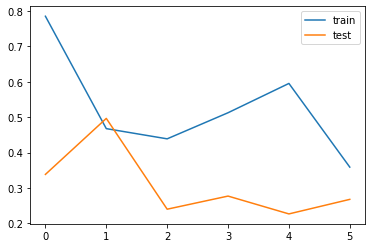

In [65]:
plt.plot(history_ms.history['loss'], label='train')
plt.plot(history_ms.history['val_loss'], label='test')
plt.legend();

In [66]:
model_ms.evaluate(X_ms_test,y_ms_test)

329/329 [==============================] - 13s 41ms/step - loss: 0.4514 - acc: 0.8174


[0.4513981342315674, 0.8174376487731934]

In [77]:
model_ms.save('./02_models/0926ms_lstm_md.h5')

**Note** The baseline of RNN LSTM model for the MS dataset is 0.82

##### Combine MS and WISDM datasets to build a baseline model

In [35]:
X_cb_train = np.concatenate((X_wd_train,X_ms_train),axis = 0 )
y_cb_train = np.concatenate((y_wd_train,y_ms_train),axis = 0 )
print(X_cb_train.shape,y_cb_train.shape)

(47260, 200, 3) (47260, 6)


In [36]:
X_cb_test = np.concatenate((X_wd_test,X_ms_test),axis = 0 )
y_cb_test = np.concatenate((y_wd_test,y_ms_test),axis = 0 )
print(X_cb_test.shape,y_cb_test.shape)

(15498, 200, 3) (15498, 6)


In [71]:
model_cb = keras.Sequential()
model_cb.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_cb_train.shape[1], X_cb_train.shape[2]]
      )
    )
)
model_cb.add(keras.layers.Dropout(rate=0.5))
model_cb.add(keras.layers.Dense(units=128, activation='relu'))
model_cb.add(keras.layers.Dense(y_cb_train.shape[1], activation='softmax'))
model_cb.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [72]:
history_cb = model_cb.fit(
    X_cb_train, y_cb_train,
    epochs=6,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)

Epoch 1/6
665/665 [==============================] - 306s 460ms/step - loss: 0.8422 - acc: 0.6946 - val_loss: 0.4112 - val_acc: 0.8347
Epoch 2/6
665/665 [==============================] - 333s 500ms/step - loss: 0.4552 - acc: 0.8398 - val_loss: 0.2997 - val_acc: 0.8915
Epoch 3/6
665/665 [==============================] - 338s 508ms/step - loss: 0.3738 - acc: 0.8666 - val_loss: 0.2615 - val_acc: 0.8989
Epoch 4/6
665/665 [==============================] - 338s 508ms/step - loss: 0.2742 - acc: 0.9058 - val_loss: 0.2217 - val_acc: 0.9350
Epoch 5/6
665/665 [==============================] - 335s 503ms/step - loss: 0.3202 - acc: 0.8890 - val_loss: 0.2648 - val_acc: 0.9107
Epoch 6/6
665/665 [==============================] - 335s 504ms/step - loss: 0.5375 - acc: 0.8067 - val_loss: 0.4213 - val_acc: 0.8390


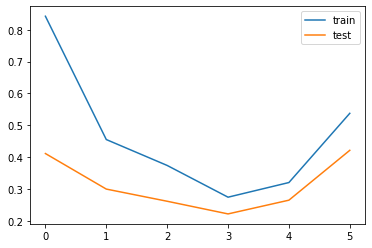

In [73]:
plt.plot(history_cb.history['loss'], label='train')
plt.plot(history_cb.history['val_loss'], label='test')
plt.legend();

In [74]:
# Evaluate the combine model on MS datasets
model_cb.evaluate(X_ms_test,y_ms_test)

329/329 [==============================] - 18s 54ms/step - loss: 0.6175 - acc: 0.7332


[0.617490828037262, 0.7332000732421875]

In [75]:
# Evaluate the combine model on WISDM datasets
model_cb.evaluate(X_wd_test,y_wd_test)

156/156 [==============================] - 7s 43ms/step - loss: 0.4464 - acc: 0.8321: 0s - loss: 0.4336 - ac


[0.4464147388935089, 0.8321313858032227]

In [76]:
# Evaluate the combine model on combined datasets
model_cb.evaluate(X_cb_test,y_cb_test)

485/485 [==============================] - 20s 41ms/step - loss: 0.5624 - acc: 0.7651


[0.5623863935470581, 0.7650664448738098]

In [78]:
model_cb.save('./02_models/0926wd_lstm_cb.h5')

**Note** The baseline of RNN LSTM model for the combined WISDM and MS datasets were:
- 0.73 for MS datasets
- 0.83 for the WISDM datasets
- 0.77 for the combined datasets

#### Summary
- In this section, three baseline models have been built with the WISDM, MS, and combined datasets using the total acceleration. These models gave the bottom lines the HAR classifiers.
- Window size was 200 samples and window shift was 40 samples were used to create the model building datasets, which could be optimized. As one will see in the folling sections, the WISDM datasets and the MS dataset should have different window sizes.
- The MS datasets had more features collected, and we expected better models could be achieved when using more features
- In this section, the model building datasets were labelled after concatenating all individual activities in to one dataframe. However, labelling them before concatenating should be more accurate.